In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import re
import random
import math
from tqdm import tqdm

# 1. Data Loading and Preprocessing

In [3]:
def tokenize(text):
    return re.findall(r'\b[a-z]{1,}\b', text.lower())


dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = ' '.join(dataset['train']['text'])

tokens = tokenize(train_text)
print(f"Total tokens: {len(tokens)}")

# Build vocabulary of top 1M words
vocab_size = 1000000
counter = Counter(tokens)
most_common = counter.most_common(vocab_size - 1)  # Reserve index 0 for <UNK>
word2idx = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
word2idx['<UNK>'] = 0
idx2word = {idx: word for word, idx in word2idx.items()}


token_indices = [word2idx.get(token, 0) for token in tokens]
del tokens 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Total tokens: 1679656


# 2. Creating Training Pairs

In [4]:
class Word2VecDataset(Dataset):
    def __init__(self, token_indices, window_size=5):
        self.token_indices = token_indices
        self.window_size = window_size
        self.length = len(token_indices)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        target = self.token_indices[idx]
        # Random window size for each target
        window = random.randint(1, self.window_size)
        # Context indices
        context = []
        for i in range(idx - window, idx + window + 1):
            if i != idx and 0 <= i < self.length:
                context.append(self.token_indices[i])
        return target, context


window_size = 5
batch_size = 512
dataset = Word2VecDataset(token_indices, window_size)

def collate_fn(batch):
    targets, contexts = zip(*batch)
    targets = torch.tensor(targets, dtype=torch.long)
    return targets, contexts

batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)


 # 3. Negative Sampling

In [5]:
# Prepare unigram distribution raised to the 3/4 power as per Mikolov et al. and others [I dont know how to put image here as well!]
word_counts = torch.Tensor([counter.get(idx2word.get(idx, '<UNK>'), 0) for idx in range(vocab_size)])
word_freq = word_counts / word_counts.sum()
unigram_dist = word_freq.pow(0.75)
unigram_dist /= unigram_dist.sum()

def get_negative_samples(batch_size, num_negatives):
    negatives = torch.multinomial(unigram_dist, batch_size * num_negatives, replacement=True)
    return negatives.view(batch_size, num_negatives)

# 4. Model Definition

In [6]:
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Initialize embeddings
        initrange = 0.5 / embedding_dim
        self.target_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.uniform_(-0, 0)  # Initialize context embeddings to 0

    def forward(self, target, context, negatives):
        embed_target = self.target_embeddings(target)  # [batch_size, embed_dim]
        embed_context = self.context_embeddings(context)  # [batch_size, embed_dim]
        embed_negatives = self.context_embeddings(negatives)  # [batch_size, neg_samples, embed_dim]

        # Positive score
        pos_score = torch.sum(embed_target * embed_context, dim=1)  # [batch_size]
        pos_loss = torch.log(torch.sigmoid(pos_score))

        # Negative score
        neg_score = torch.bmm(embed_negatives, embed_target.unsqueeze(2)).squeeze()  # [batch_size, neg_samples]
        neg_loss = torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1)  # [batch_size]

        # Total loss
        loss = -(pos_loss + neg_loss)
        return loss.mean()

# Initialize model
embedding_dim = 300
model = SkipGramNegSampling(vocab_size, embedding_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SkipGramNegSampling(
  (target_embeddings): Embedding(1000000, 300)
  (context_embeddings): Embedding(1000000, 300)
)

# 5. Training the Model

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
num_negatives = 5 

for epoch in range(num_epochs):
    total_loss = 0
    progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_targets, batch_contexts in progress:
        batch_size_current = batch_targets.size(0)
        batch_targets = batch_targets.to(device)

        # Flatten context lists and create target-context pairs
        batch_contexts = [context for context in batch_contexts]
        # To handle variable number of contexts per target, we can sample one context per target randomly
        # Alternatively, iterate through all context words
        # For simplicity and efficiency, we'll sample one context per target
        sampled_contexts = [random.choice(context) if context else 0 for context in batch_contexts]
        sampled_contexts = torch.tensor(sampled_contexts, dtype=torch.long).to(device)

        # Get negative samples
        negatives = get_negative_samples(batch_size_current, num_negatives).to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        loss = model(batch_targets, sampled_contexts, negatives)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress.set_postfix({'Loss': total_loss / (progress.n + 1)})

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")



Epoch 1/5: 100%|██████████| 3281/3281 [12:23<00:00,  4.41it/s, Loss=2.69]


Epoch 1, Average Loss: 2.6854


Epoch 2/5: 100%|██████████| 3281/3281 [12:22<00:00,  4.42it/s, Loss=2.41]


Epoch 2, Average Loss: 2.4060


Epoch 3/5: 100%|██████████| 3281/3281 [12:22<00:00,  4.42it/s, Loss=2.33]


Epoch 3, Average Loss: 2.3330


Epoch 4/5: 100%|██████████| 3281/3281 [12:22<00:00,  4.42it/s, Loss=2.29]


Epoch 4, Average Loss: 2.2887


Epoch 5/5: 100%|██████████| 3281/3281 [12:22<00:00,  4.42it/s, Loss=2.25]

Epoch 5, Average Loss: 2.2525


# 6. Saving and Using Embeddings

In [8]:

embeddings = model.target_embeddings.weight.data.cpu()
torch.save(embeddings, 'word_embeddings.pt')

def get_embedding(word):
    idx = word2idx.get(word, 0)
    return embeddings[idx].numpy()

# Example usage
word = 'king'
embedding_vector = get_embedding(word)
print(f"Embedding for '{word}':\n{embedding_vector}")

import numpy as np
np.save('embeddings.npy', embeddings.numpy())
with open('word2idx.txt', 'w') as f:
    for word, idx in word2idx.items():
        f.write(f"{word}\t{idx}\n")

print("Embeddings and word2idx mapping saved successfully!")


Embedding for 'king':
[-1.72479659e-01 -1.39342859e-01  1.41578987e-01 -6.04248457e-02
  1.41499534e-01 -1.25593275e-01 -1.00851007e-01  1.29344240e-01
 -6.30311221e-02 -5.50983325e-02 -2.49349773e-01 -2.22073823e-01
  1.57329947e-01  3.87879126e-02  3.95917505e-01 -2.11938128e-01
 -2.22156435e-01  7.15197250e-02  2.05583587e-01  9.64149907e-02
  1.26729205e-01 -8.42230469e-02 -2.59446502e-01  2.55250067e-01
 -3.80830653e-02  3.19318175e-01 -2.03190565e-01 -2.43745938e-01
 -2.51835108e-01 -2.73068875e-01  6.86860532e-02 -4.00029570e-02
  3.07004321e-02  7.87741691e-02 -1.49425149e-01  2.48331055e-02
  9.78076681e-02  8.08743015e-02  1.12929292e-01  1.60463884e-01
 -9.10975635e-02  1.02479286e-01  3.10672015e-01  7.54799619e-02
  3.02688859e-04  6.45965561e-02  1.79391861e-01 -1.97665289e-01
  1.75903514e-01  2.05669969e-01 -1.57040820e-01  6.61718473e-02
  1.98696688e-01 -3.04164261e-01  4.10346081e-03 -2.36041903e-01
 -9.23859626e-02 -2.36351162e-01 -2.57742137e-01  8.84938166e-02
 -1

In [10]:
import numpy as np
import torch

try:
    embeddings = np.load('embeddings.npy')
    print("Loaded embeddings.npy successfully.")
except FileNotFoundError:
    print("embeddings.npy not found. Attempting to load word_embeddings.pt...")
    try:
        embeddings = torch.load('word_embeddings.pt').cpu().numpy()
        print("Loaded word_embeddings.pt successfully.")
    except FileNotFoundError:
        raise FileNotFoundError("Neither embeddings.npy nor word_embeddings.pt was found. Please upload one of these files.")

# Load word2idx mapping from 'word2idx.txt'
word2idx = {}
try:
    with open('word2idx.txt', 'r', encoding='utf-8') as f:
        for line in f:
            word, idx = line.strip().split('\t')
            word2idx[word] = int(idx)
    print("Loaded word2idx.txt successfully.")
except FileNotFoundError:
    raise FileNotFoundError("word2idx.txt not found. Please upload the word2idx.txt file.")


Loaded embeddings.npy successfully.
Loaded word2idx.txt successfully.


In [11]:
def get_embedding(word):
    idx = word2idx.get(word.lower(), 0)  # Default to index 0 if word not found
    return embeddings[idx]


In [12]:
import pandas as pd

simlex_path = 'SimLex-999.txt'

try:
    simlex_df = pd.read_csv(simlex_path, sep='\t')
    print("Loaded SimLex-999 dataset successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"SimLex-999 file not found at {simlex_path}. Please upload the SimLex-999.txt file.")

print("\nFirst few entries in SimLex-999:")
print(simlex_df.head())

required_columns = {'word1', 'word2', 'SimLex999'}
if not required_columns.issubset(simlex_df.columns):
    raise ValueError(f"SimLex-999 file must contain the columns: {required_columns}")


Loaded SimLex-999 dataset successfully.

First few entries in SimLex-999:
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


In [13]:
from sklearn.metrics.pairwise import cosine_similarity


human_scores = []
model_similarities = []

missing_pairs = 0

for index, row in simlex_df.iterrows():
    word1 = row['word1'].lower()
    word2 = row['word2'].lower()
    human_score = row['SimLex999']

    # Retrieve embeddings for both words
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    # Check if either word is unknown (i.e., mapped to index 0)
    if word2idx.get(word1, 0) == 0 or word2idx.get(word2, 0) == 0:
        missing_pairs += 1
        continue  # Skip pairs with missing embeddings

    # Compute cosine similarity
    # Reshape embeddings to 2D arrays for sklearn's cosine_similarity
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)
    cosine_sim = cosine_similarity(emb1, emb2)[0][0]

    # Append to lists
    human_scores.append(human_score)
    model_similarities.append(cosine_sim)


In [14]:
from scipy.stats import spearmanr

# Report the number of skipped pairs
total_pairs = len(simlex_df)
print(f"\nTotal word pairs in SimLex-999: {total_pairs}")
print(f"Word pairs with missing embeddings skipped: {missing_pairs}")
print(f"Word pairs used for evaluation: {len(human_scores)}")

# Convert lists to numpy arrays
human_scores = np.array(human_scores)
model_similarities = np.array(model_similarities)

# Calculate Spearman's rank correlation
spearman_corr, spearman_p = spearmanr(human_scores, model_similarities)
print(f"\nSpearman's rank correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")



Total word pairs in SimLex-999: 999
Word pairs with missing embeddings skipped: 14
Word pairs used for evaluation: 985

Spearman's rank correlation: 0.1363 (p-value: 1.7614e-05)


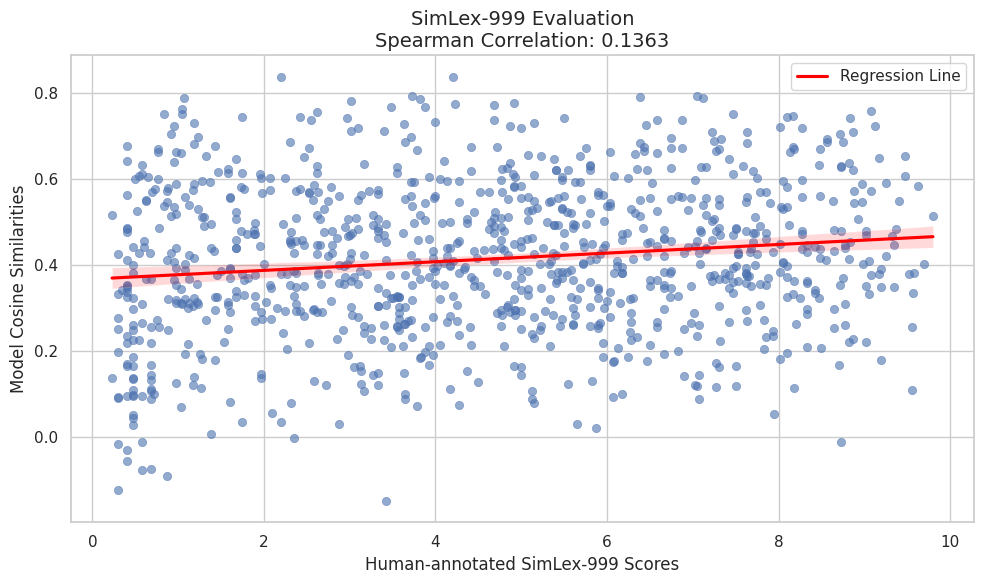

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.scatterplot(x=human_scores, y=model_similarities, alpha=0.6, edgecolor=None)
sns.regplot(x=human_scores, y=model_similarities, scatter=False, color='red', label='Regression Line')
plt.xlabel('Human-annotated SimLex-999 Scores', fontsize=12)
plt.ylabel('Model Cosine Similarities', fontsize=12)
plt.title(f'SimLex-999 Evaluation\nSpearman Correlation: {spearman_corr:.4f}', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
